<a href="https://colab.research.google.com/github/Abhilash11Addanki/DeepLearning/blob/main/Shakespeare_Poetry_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
import numpy as np

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2021-05-12 05:50:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 64.233.184.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-05-12 05:50:51 (91.2 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
data = open('/tmp/sonnets.txt').read()
corpus = data.lower().split("\n")

In [4]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)+1
print(total_words)

3212


In [5]:
input_seq = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    n_gram_seq = token_list[:i+1]
    input_seq.append(n_gram_seq)

In [6]:
max_seq_len = max([len(x) for x in input_seq])
input_seq = np.array(pad_sequences(input_seq,maxlen=max_seq_len,padding='pre'))

In [7]:
predictors,labels = input_seq[:,:-1],input_seq[:,-1]
labels = tf.keras.utils.to_categorical(labels,num_classes=total_words)

In [8]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_words,100,input_length=max_seq_len-1),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,return_sequences=True)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
                                    tf.keras.layers.Dense(total_words/2,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                                    tf.keras.layers.Dense(total_words,activation='softmax')])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321200    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 1606)              322806    
_________________________________________________________________
dense_1 (Dense)              (None, 3212)              5161684   
Total params: 6,427,690
Trainable params: 6,427,690
Non-trainable params: 0
______________________________________________

In [10]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy')>0.95:
      print("\nReached 95% accuracy so training cancelled")
      self.model.stop_training = True

In [12]:
history = model.fit(predictors,labels,epochs = 100,callbacks=[myCallback()])

Epoch 1/100
484/484 [==============================] - 50s 32ms/step - loss: 7.5489 - accuracy: 0.0207
Epoch 2/100
484/484 [==============================] - 16s 33ms/step - loss: 6.4893 - accuracy: 0.0224
Epoch 3/100
484/484 [==============================] - 16s 32ms/step - loss: 6.3894 - accuracy: 0.0240
Epoch 4/100
484/484 [==============================] - 16s 32ms/step - loss: 6.2561 - accuracy: 0.0309
Epoch 5/100
484/484 [==============================] - 15s 32ms/step - loss: 6.1624 - accuracy: 0.0369
Epoch 6/100
484/484 [==============================] - 15s 32ms/step - loss: 6.0513 - accuracy: 0.0386
Epoch 7/100
484/484 [==============================] - 16s 32ms/step - loss: 5.9761 - accuracy: 0.0405
Epoch 8/100
484/484 [==============================] - 16s 33ms/step - loss: 5.8293 - accuracy: 0.0491
Epoch 9/100
484/484 [==============================] - 16s 33ms/step - loss: 5.7188 - accuracy: 0.0539
Epoch 10/100
484/484 [==============================] - 15s 32ms/step - l

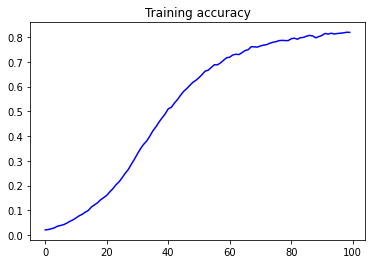

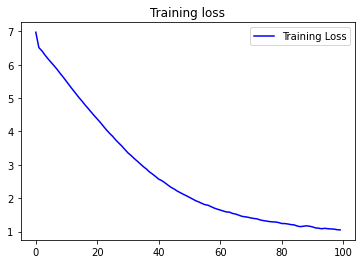

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [15]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope dead night new rare twain light light twain night away bright one night new and away grew of foes sense time arising date of praise arising arising light away ' away me grew new strong odours still in thee new free lie to thee time thy rare night new rare away ' away none lie to you was so long of view in your verse can sit sit sit grew new looks away appetite seen twain toil'd twain date wide face so face other bright mine eye untrue days rare view state away none new gone from the vanish'd night
